# 5. Inference

This notebook, part of the analysis phase of the project, is centered around inference and evaluation of the selected model in the test dataset.

In [4]:
# Necessary imports
import polars as pl
import sys

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


from torch.utils.data import (
    DataLoader,
    TensorDataset,
)

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed
from src.utils.model_utils import (
    evaluate_model,
    plot_inference_report
)

# Set the seed for reproducibility
rng = set_seed()


In [5]:
# Directory management
DATA_DIR = ROOT_DIR / "data"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"

MODELS_DIR = ROOT_DIR / "models"

OUTPUT_DIR = ROOT_DIR / "output"
RESULTS_DIR = OUTPUT_DIR / "model_selection"


### 1. Load and process the HateXplain Dataset

In [6]:
# Load the dataframe
df_test = pl.read_parquet(SPLITTED_DATA_DIR / "test_2_classes.parquet")


In [7]:
# Label encoding
label2id = {"normal": 0, "hatespeech": 1}
id2label = {id_: label for label, id_ in label2id.items()}
target_labels = list(label2id.keys())

df_test = df_test.with_columns(
    pl.col("label").replace_strict(label2id),
)


In [8]:
# Create the X, y splits
X_test = df_test["tokens"].to_list()
y_test = df_test["label"].to_list()


### 2. Evaluate the BERT model

In the model selection phase, the best performing model on validation was BERT for sequence classification. We will evaluate it here on the test set.

In [9]:
# Tokenization and encoding
tokenizer = AutoTokenizer.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)
def encode(
    text_items: list[str],
    tokenizer: AutoTokenizer,
    max_length: int = 128,
) -> dict:
    """Encode the input text using the provided tokenizer."""
    return tokenizer(text_items,
                is_split_into_words=True,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt")


In [10]:
# Encode the training and validation datasets
X_test_encoded = encode(X_test, tokenizer)


In [11]:
# Data preparation
labels_test = torch.tensor(y_test)

dataset_test = TensorDataset(
    X_test_encoded["input_ids"],
    X_test_encoded["attention_mask"],
    labels_test,
)

batch_size = 1
test_dataloader = DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)


In [12]:
# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model
model_clf = AutoModelForSequenceClassification.from_pretrained(
    RESULTS_DIR / "bert-base-uncased_2_classes",
    num_labels=len(target_labels),
)

model_clf.to(device)
if model_clf.device.type == "cuda":
    print("Successfully loaded the model to the GPU.")
else:
    print("WARNING: Could not load the model to the GPU. Using CPU instead.\nErrors may occur.")


torch.multiprocessing.set_start_method("spawn", force=True)

# Evaluation of the model on the validation set
correct, total, all_predictions, all_labels, all_probabilities = evaluate_model(
    model_clf,
    test_dataloader,
    device=device,
)



2025-06-09 16:16:48.140310: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 16:16:48.202506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 16:16:48.215397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 16:16:48.220671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 16:16:48.291833: I tensorflow/core/platform/cpu_feature_guar

Successfully loaded the model to the GPU.


Running validation: 100%|██████████| 1376/1376 [00:12<00:00, 114.32batch/s]


Test Accuracy: 0.90
              precision    recall  f1-score   support

      normal     0.9197    0.9079    0.9138       782
  hatespeech     0.8808    0.8956    0.8881       594

    accuracy                         0.9026      1376
   macro avg     0.9002    0.9018    0.9010      1376
weighted avg     0.9029    0.9026    0.9027      1376



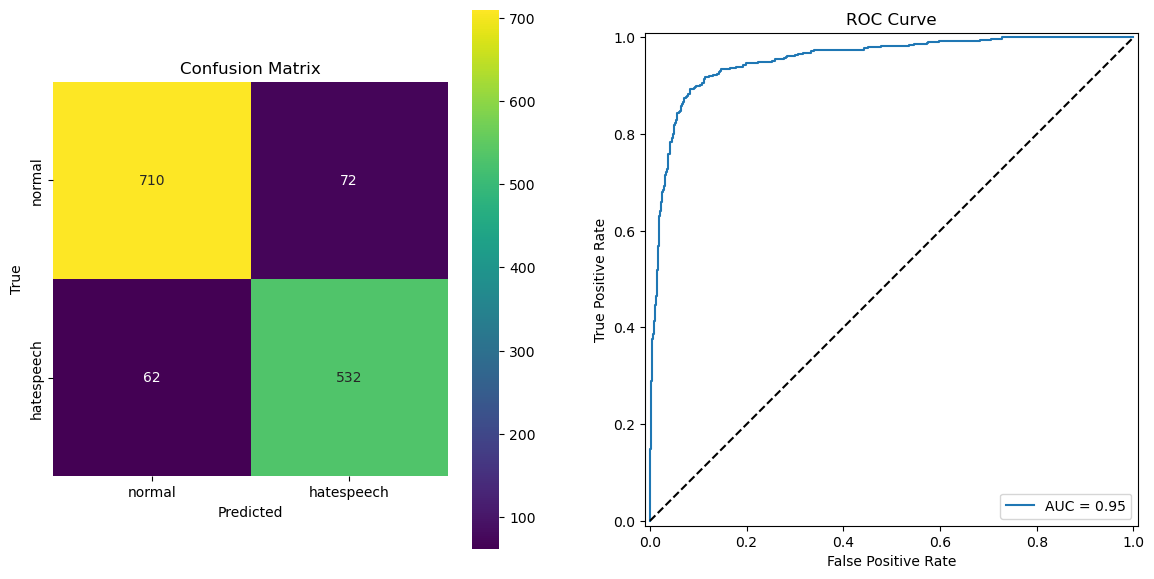

In [13]:
fig, axs = plot_inference_report(
    correct,
    total,
    target_labels,
    all_predictions,
    all_labels,
    all_probabilities,
)



In [14]:
post = df_test.filter(pl.col("post_id") == "13380605_gab")
x = encode(post["tokens"].to_list()[0], tokenizer)
model_clf.eval()
with torch.no_grad():
    logits = model_clf(
        x["input_ids"].to(device),
        attention_mask=x["attention_mask"].to(device),
    ).logits
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_class = probabilities.argmax()
    predicted_label = id2label[predicted_class]
    predicted_prob = probabilities[predicted_class]
    print(f"Predicted label: {predicted_label}")
    print(f"Predicted probability: {predicted_prob:.4f}")
    print(f"True label: {id2label[post['label'].to_list()[0]]}")


Predicted label: hatespeech
Predicted probability: 0.8703
True label: hatespeech


72
80
87
96
125
132
191
207
210
251
281
300
322
343
386
396
409
470
472
494
559
675
703
709
711
778
815
842
888
899
914
918
924
1094
1108
1229
1230
1268


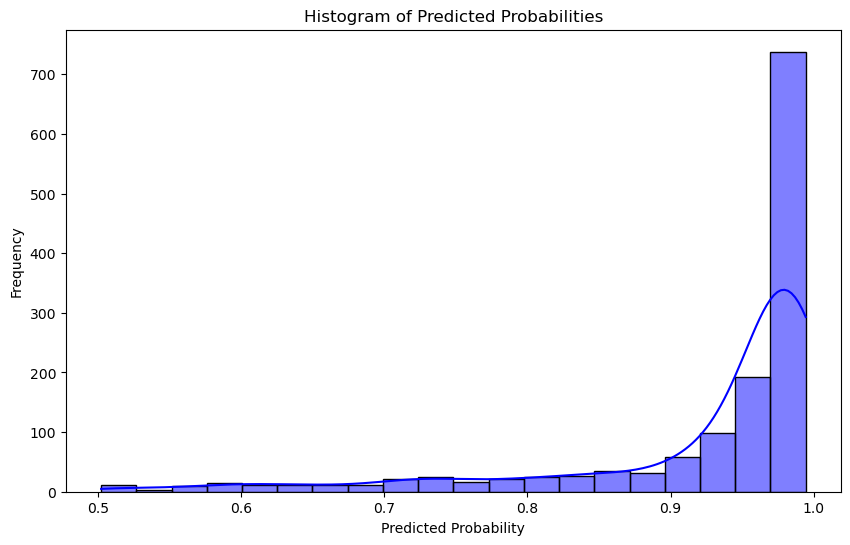

In [15]:
plt.figure(figsize=(10, 6))

probs = []
for i, (pred, prob) in enumerate(zip(all_predictions, all_probabilities)):
    if pred == 0:
        probs.append(1. - prob)
    if pred == 1:
        probs.append(prob)
    if probs[i] < 0.6:
        print(i)

sns.histplot(probs, bins=20, kde=True, color='blue')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()
